In [79]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [80]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [81]:
# Save the input and target variables
# print(diabetes_dataset.keys())
data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]

In [82]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis = 0)) / targets.std()


In [83]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size = 0.1)
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [84]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation = "relu", input_shape=(train_data.shape[1],)),
        Dense(128, activation = "relu"),
        Dense(128, activation = "relu"),
        Dense(128, activation = "relu"),
        Dense(128, activation = "relu"),
        Dense(128, activation = "relu"),
        Dense(1)
    ])
    return model

model = get_model()

In [85]:
# Print the model summary
model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_50 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_51 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_52 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_53 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_54 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_55 (Dense)             (None, 1)                

In [86]:
# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])


In [87]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs = 100, validation_split = 0.15, batch_size = 64, verbose=False)

In [88]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose = 2)

45/1 - 0s - loss: 0.8216 - mae: 0.7328


[0.846405749850803, 0.73276234]

#### Plot the learning curves

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

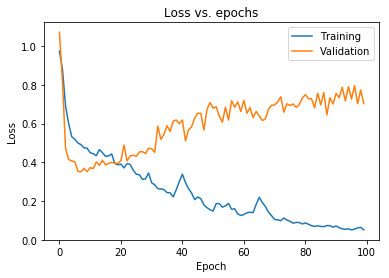

In [90]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [91]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [92]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [93]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)


In [94]:
# Compile the model
model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])


In [95]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs = 100, validation_split = 0.15, batch_size = 64, verbose=False)

In [96]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose = 2)

45/1 - 0s - loss: 0.6925 - mae: 0.5784


[0.5700836737950643, 0.5783557]

#### Plot the learning curves

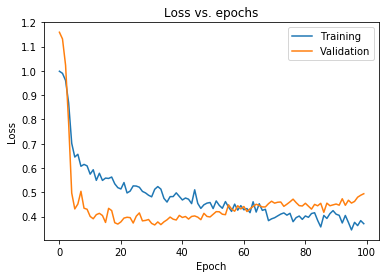

In [97]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [109]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self, logs=None):
        print("Starting Training...")
    
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
    
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting batch {batch}")
    
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finished batch {batch}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")
        
    def on_train_end(self, logs=None):
        print("Finished Training!")
        
class TestingCallback(Callback):
    
    def on_test_begin(self, logs=None):
        print("Starting Testing...")
    
    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Starting batch {batch}")
    
    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing: Finished batch {batch}")
        
    def on_test_end(self, logs=None):
        print("Finished Testing!")
        
class PredictionCallback(Callback):
    
    def on_predict_begin(self, logs=None):
        print("Starting Predictions...")
    
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Preditcting: Starting batch {batch}")
    
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Preditcting: Finished batch {batch}")
        
    def on_predict_end(self, logs=None):
        print("Finished Predicting!")

In [110]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

In [111]:
# Compile the model
model.compile(optimizer = "adam", loss = "mse")


#### Train the model with the callback

In [112]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_targets, epochs = 3, batch_size=128, verbose=False, callbacks=[TrainingCallback()])

Starting Training...
Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 2
Finished Training!


In [115]:
# Evaluate the model
model.evaluate(test_data, test_targets, verbose = False, callbacks=[TestingCallback()])


Starting Testing...
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Finished Testing!


0.8163357973098755

In [116]:
# Make predictions with the model
model.predict(test_data, verbose = False, callbacks=[PredictionCallback()])


Starting Predictions...
Preditcting: Starting batch 0
Preditcting: Finished batch 0
Preditcting: Starting batch 1
Preditcting: Finished batch 1
Finished Predicting!


array([[-0.10076307],
       [-0.04336343],
       [-0.04033083],
       [ 0.00593058],
       [-0.10252024],
       [-0.02615426],
       [-0.08319496],
       [-0.16512235],
       [-0.02936114],
       [-0.02264757],
       [-0.11147258],
       [-0.04997782],
       [-0.07609335],
       [-0.09442288],
       [-0.00584398],
       [-0.04218808],
       [-0.01514097],
       [-0.05742115],
       [-0.03565575],
       [-0.10267347],
       [-0.00581664],
       [-0.00649103],
       [-0.07953269],
       [-0.03646623],
       [-0.02782714],
       [-0.09371562],
       [-0.14133224],
       [-0.01298438],
       [-0.06511983],
       [-0.11724393],
       [-0.15811482],
       [-0.04163397],
       [-0.11259523],
       [-0.10705496],
       [-0.1451875 ],
       [-0.1271415 ],
       [-0.01720108],
       [-0.11125928],
       [-0.00823834],
       [-0.0571414 ],
       [-0.09920885],
       [-0.11330646],
       [-0.06616139],
       [ 0.00122504],
       [-0.08617204]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [130]:
# Re-train the unregularised model

unregularised_model = get_model()
unregularised_model.compile(optimizer="adam", loss="mse")
unreg_history = unregularised_model.fit(train_data, train_targets, epochs = 100,
                                       validation_split = 0.15, batch_size = 64, verbose = False,
                                       callbacks=[tf.keras.callbacks.EarlyStopping(patience = 2)])

In [131]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.5292


0.48332395950953166

In [132]:
# Re-train the regularised model

regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer="adam", loss="mse")
reg_history = regularised_model.fit(train_data, train_targets, epochs = 100,
                                       validation_split = 0.15, batch_size = 64, verbose = False,
                                       callbacks=[tf.keras.callbacks.EarlyStopping(patience = 2)])

In [133]:
# Evaluate the model on the test set

regularised_model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.5478


0.4944124513202243

#### Plot the learning curves

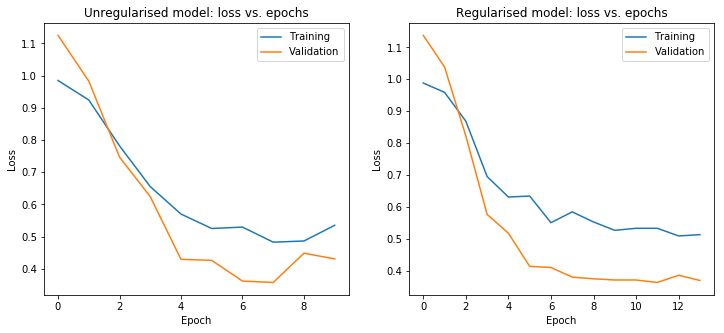

In [134]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()